In [1]:
import numpy as np
import pandas as pd
import numpyro
import numpyro.distributions as dist
from jax import random
from numpyro.infer import MCMC, NUTS, Predictive
from numpyro.diagnostics import hpdi
import jax.numpy as jnp
import arviz as az
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

/home/beria/Documents/malaria-project/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = pd.read_csv('../../data/panel_data.csv')

data['time'] = pd.to_datetime(data['time'])
data['month'] = data['time'].dt.month
data['year'] = data['time'].dt.year
data['cases'] = data['cases'].astype(int)
data = data[['state','year','month','cases', 't2m','tp']]
data = data.sort_values(by=['state', 'year', 'month'])  # Ensure data is sorted
data = pd.get_dummies(data, columns=['state', 'year', 'month'], drop_first=False)

X = data[['t2m','tp'] + [col for col in data.columns if col.startswith('state_') or col.startswith('year_') or col.startswith('month_')]]
y = data['cases']
# data['lag_cases'] = data.groupby('state')['cases'].shift(1)
# data = data.dropna(subset=['lag_cases'])
# data = pd.get_dummies(data, columns=['state', 'month'], drop_first=False)
# states = [element.split('_')[1] for element in data.columns if element.startswith('state')]
data.head()

,cases,t2m,tp,state_BAHR EL GAZEL,state_BATHA,state_BORKOU,state_CHARI BAGUIRMI,state_ENNEDI EST,state_ENNEDI OUEST,state_GUERA,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
10,259,19.761659,0.001129,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
33,165,21.966063,0.001508,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
56,112,29.094683,0.000762,True,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
79,160,32.909817,0.000761,True,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
102,127,34.160160,0.006172,True,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False


In [3]:
import pandas as pd
import statsmodels.api as sm
import jax.numpy as jnp

# Assume `df` is your DataFrame with the necessary columns
X_train_const = sm.add_constant(X)
y_train_numpy = np.array(y)
X_train_const_numpy = np.array(X_train_const.to_numpy().tolist())
y_train_numpy = np.array(y.values.tolist())

# X_train = jnp.array(data_train[['lag_cases','t2m', 'tp'] + [col for col in data_train.columns if col.startswith('state_') or col.startswith('month_')]].values.tolist())
# y_train = jnp.array(data_train['cases'].values.astype(int).tolist())

nb_model = sm.GLM(y_train_numpy, X_train_const_numpy, family=sm.families.NegativeBinomial(alpha=0.7)).fit()
print(nb_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                 1104
Model:                            GLM   Df Residuals:                     1065
Model Family:        NegativeBinomial   Df Model:                           38
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -9382.8
Date:                Mon, 25 Nov 2024   Deviance:                       432.41
Time:                        00:09:48   Pearson chi2:                     386.
No. Iterations:                    12   Pseudo R-squ. (CS):             0.9045
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.2967      0.273     19.423      0.0

In [4]:
y_train = y_train_numpy
X_train = X_train_const_numpy

## 2.1. Overdispersion

In [5]:
import numpy as np

# Calculate the mean and variance of the response variable
mean_y = np.mean(y_train)
variance_y = np.var(y_train)

# Check if overdispersion is present (variance > mean)
print(f"Mean of y_train: {mean_y}")
print(f"Variance of y_train: {variance_y}")
if variance_y > mean_y:
    print("Overdispersion is present; Negative Binomial is a good fit.")
else:
    print("No overdispersion detected; consider a Poisson model.")


Mean of y_train: 4745.457427536232
Variance of y_train: 31842434.0869557
Overdispersion is present; Negative Binomial is a good fit.


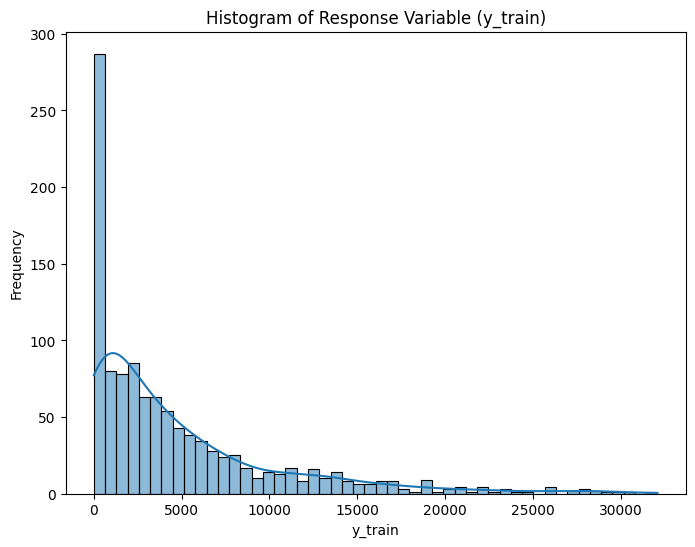

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot histogram of the response variable y_train
plt.figure(figsize=(8, 6))
sns.histplot(y_train, kde=True, bins=50)
plt.title("Histogram of Response Variable (y_train)")
plt.xlabel("y_train")
plt.ylabel("Frequency")
plt.show()

## 2.2. Linearity Check (for Log Link)

In [7]:
X_train_const

,const,t2m,tp,state_BAHR EL GAZEL,state_BATHA,state_BORKOU,state_CHARI BAGUIRMI,state_ENNEDI EST,state_ENNEDI OUEST,state_GUERA,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
10,1.0,19.761659,0.001129,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
33,1.0,21.966063,0.001508,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
56,1.0,29.094683,0.000762,True,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
79,1.0,32.909817,0.000761,True,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
102,1.0,34.160160,0.006172,True,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
992,1.0,28.563262,1.064246,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
1015,1.0,30.720729,0.231967,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
1038,1.0,30.087666,0.011532,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
1061,1.0,27.235060,0.000475,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False


In [123]:
X_train[:,2:4].shape

(1104, 2)

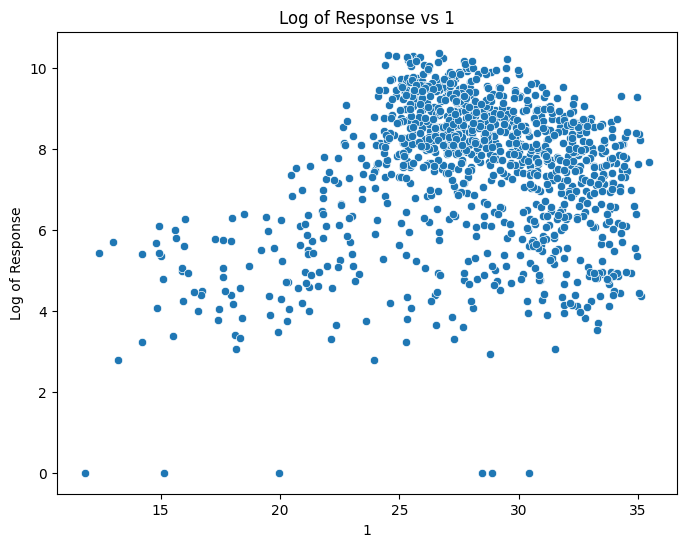

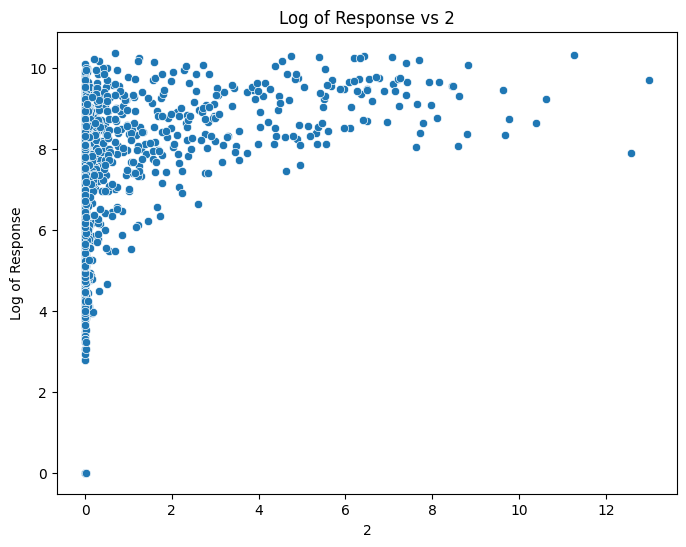

In [144]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the log-transformed response variable vs each predictor
for column in range(1,3):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X_train[:,column], y=np.log(y_train + 1))  # log(y + 1) in case of zero values
    plt.title(f"Log of Response vs {column}")
    plt.xlabel(column)
    plt.ylabel("Log of Response")
    plt.show()


## 2.3. Independence Check (Autocorrelation)

In [145]:
from statsmodels.stats.stattools import durbin_watson

# Get the residuals from the model
residuals = nb_model.resid_response

# Durbin-Watson statistic to check for autocorrelation
dw_stat = durbin_watson(residuals)
print(f"Durbin-Watson statistic: {dw_stat}")

# Interpretation
if dw_stat < 1.5:
    print("There may be positive autocorrelation.")
elif dw_stat > 2.5:
    print("There may be negative autocorrelation.")
else:
    print("No significant autocorrelation detected.")


Durbin-Watson statistic: 0.7231695833567244
There may be positive autocorrelation.


## 2.4. Multicollinearity Check (VIF)

In [109]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate VIF for each predictor
X_train_const_numpy = np.array(X_train_const)  # Ensure it's a NumPy array
vif_data = pd.DataFrame()
vif_data["Variable"] = ['t2m', 'tp']
vif_data["VIF"] = [variance_inflation_factor(X_train, i) for i in range(1,3)]

print(vif_data)


  Variable       VIF
0      t2m  4.409927
1       tp  4.498813


## 2.5. Homoscedasticity Check (Constant Variance of Errors)

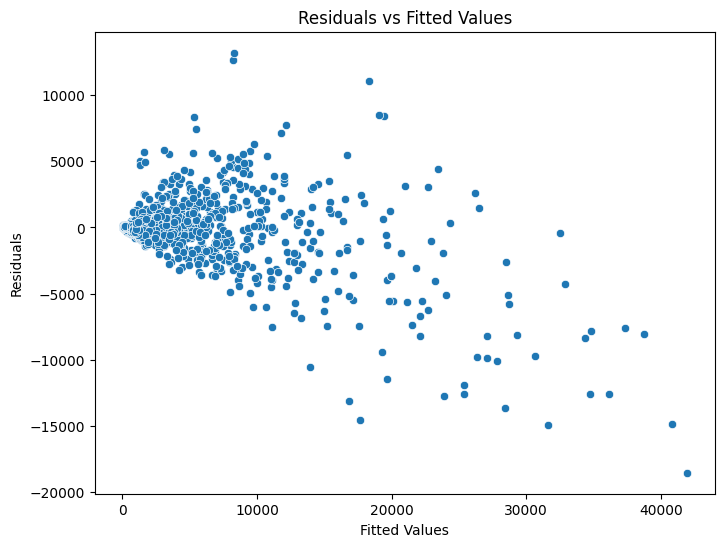

In [111]:
# Residuals vs fitted values plot
fitted_values = nb_model.fittedvalues
plt.figure(figsize=(8, 6))
sns.scatterplot(x=fitted_values, y=residuals)
plt.title("Residuals vs Fitted Values")
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.show()

# Check for patterns: a random scatter indicates homoscedasticity

## 2.6. Model Fit Check (AIC/BIC, Pseudo-R², and Likelihood Ratio Test)

In [114]:
# AIC, BIC, and McFadden's pseudo-R²
print(f"AIC: {nb_model.aic}")
print(f"BIC: {nb_model.bic}")
print(f"McFadden's Pseudo R²: {1 - (nb_model.llf / nb_model.llnull)}")


AIC: 18379.94741489685
BIC: -6037.715587690788
McFadden's Pseudo R²: 0.33078133184125413


## 2.7. Outliers and Influential Data Points (Cook’s Distance and Leverage)

<Figure size 1500x1500 with 0 Axes>

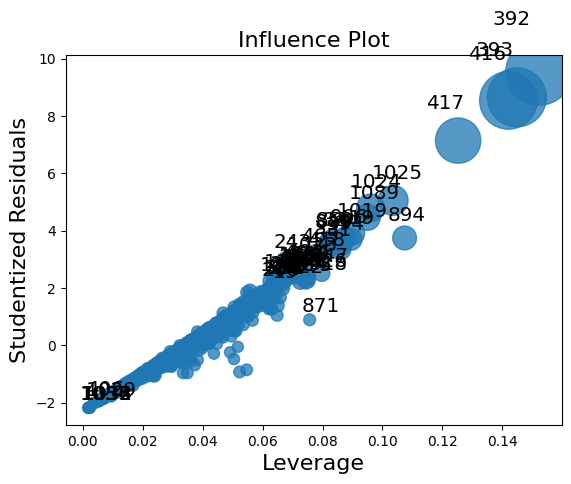

In [115]:
from statsmodels.graphics.regressionplots import influence_plot

# Influence plot to detect outliers and leverage
# Set 'external' to False to avoid the external studentized residuals error
plt.figure(figsize=(15, 15))
influence_plot(nb_model, external=False)  # Avoid the external residuals
plt.show()


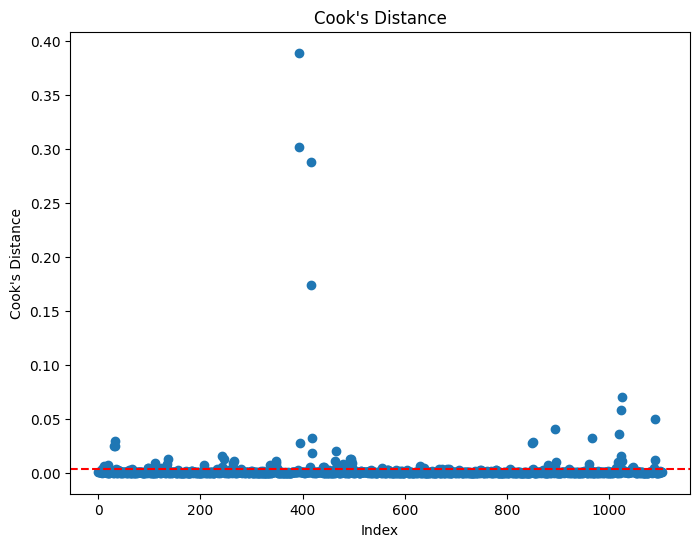

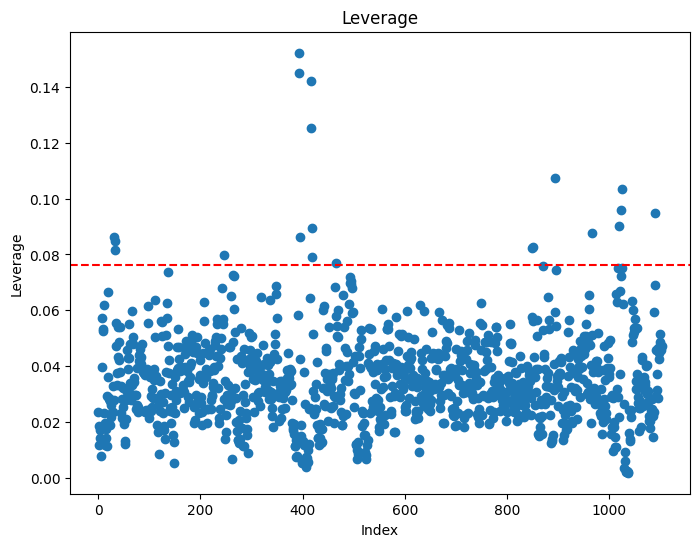

In [116]:
# Get the influence measures from the model
influence = nb_model.get_influence()

# Get Cook's distance
cooks_d = influence.cooks_distance[0]

# Get leverage values
leverage = influence.hat_matrix_diag

# Plot Cook's Distance
plt.figure(figsize=(8, 6))
plt.scatter(range(len(cooks_d)), cooks_d)
plt.axhline(y=4/len(y_train), color='r', linestyle='--')  # A threshold for influence
plt.title("Cook's Distance")
plt.xlabel("Index")
plt.ylabel("Cook's Distance")
plt.show()

# Plot Leverage values
plt.figure(figsize=(8, 6))
plt.scatter(range(len(leverage)), leverage)
plt.axhline(y=2 * (X_train_const.shape[1] / len(y_train)), color='r', linestyle='--')  # Leverage threshold
plt.title("Leverage")
plt.xlabel("Index")
plt.ylabel("Leverage")
plt.show()


## 2.8. Model Specification Check (Link Test):

In [54]:
X_train_const.shape

(943, 39)

In [118]:
# Link test for model specification
from statsmodels.tools import add_constant

# Create the link variable (predicted values)
# X_train_const["link"] = nb_model.fittedvalues
link_model = sm.GLM(y_train, nb_model.fittedvalues, family=sm.families.NegativeBinomial()).fit()

# Link test: the link variable should not be significant if the model is correctly specified
print(link_model.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                 1104
Model:                            GLM   Df Residuals:                     1103
Model Family:        NegativeBinomial   Df Model:                            0
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -36735.
Date:                Thu, 21 Nov 2024   Deviance:                   1.5632e+08
Time:                        17:22:19   Pearson chi2:                 9.53e+05
No. Iterations:                   100   Pseudo R-squ. (CS):         -4.792e+20
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0040   3.76e-06   1055.835      0.0

/home/beria/Documents/malaria-project/venv/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


## 2.9. Residual Diagnostics (Normality of Residuals)

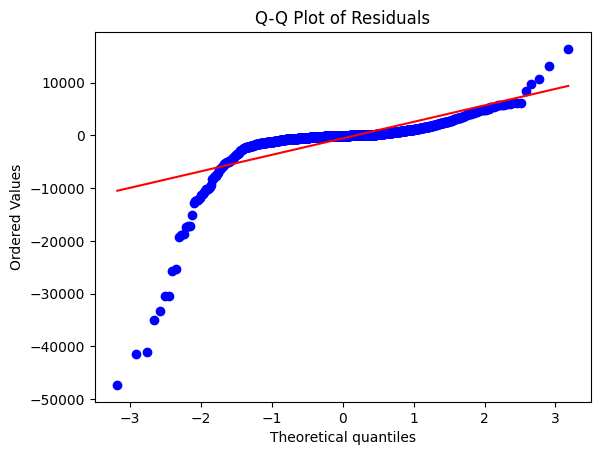

In [ ]:
import scipy.stats as stats

# Q-Q plot for normality of residuals
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()

## 2.10. Goodness of Fit (Deviance Residuals)

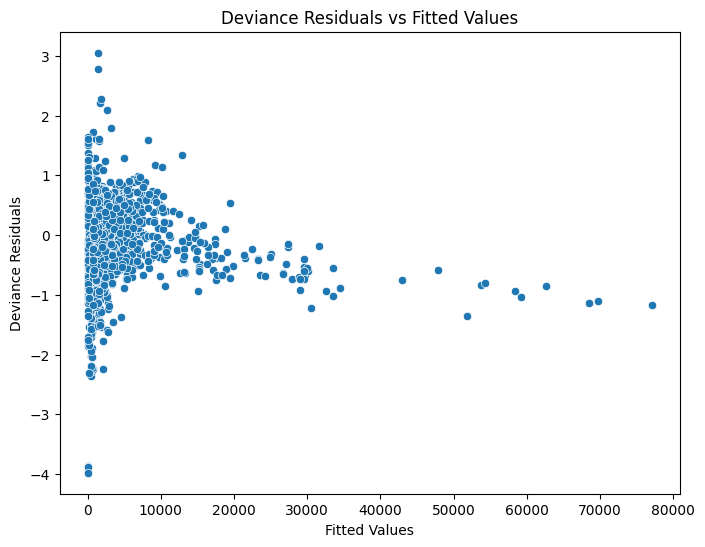

In [56]:
# Deviance residuals plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=fitted_values, y=nb_model.resid_deviance)
plt.title("Deviance Residuals vs Fitted Values")
plt.xlabel("Fitted Values")
plt.ylabel("Deviance Residuals")
plt.show()


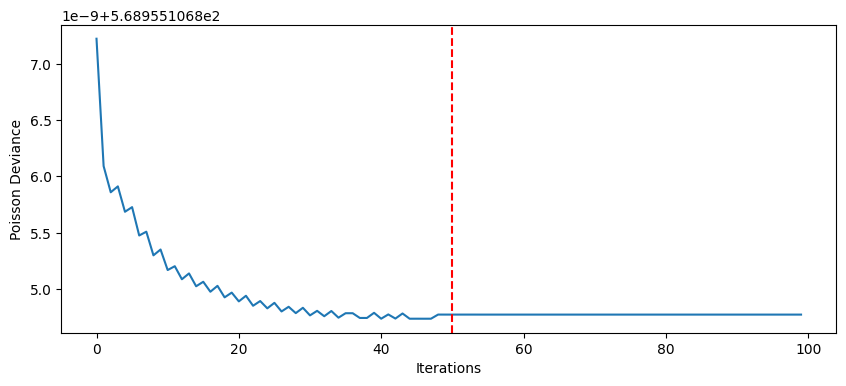

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(losses)
ax.set_xlabel("Iterations")
ax.set_ylabel("Poisson Deviance")
# plt.title("Convergence of Poisson Regressor")
ax.axvline(x=50, color='red', linestyle='--')
plt.show()

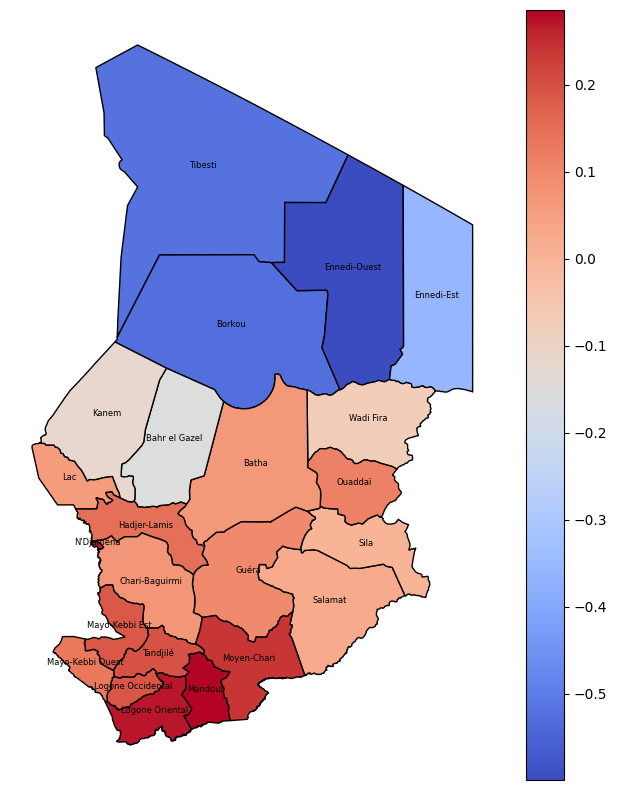

In [33]:
import cartopy.crs as ccrs
import geopandas as gpd

space_coefficients = coefficients['beta_state']
map_data = gpd.read_file('../../data/chadgeodata/geoBoundaries-TCD-ADM1-all/geoBoundaries-TCD-ADM1.geojson')
map_data.loc[21, 'shapeName'] = "N'Djamena"
shape_names = map_data['shapeName'].tolist()
shape_names.sort()
map_data['risk'] = [None]*23
for element in shape_names:
    map_data.loc[map_data['shapeName']==element, 'risk'] = space_coefficients[shape_names.index(element)]
map_data['risk'] = pd.to_numeric(map_data['risk'], errors='coerce')

map_data = map_data.to_crs(epsg=3857) 

fig, ax = plt.subplots(1, 1, figsize=(8, 10))

# ax = plt.axes(projection=ccrs.PlateCarree())
map_data.plot(edgecolor='black', column='risk', cmap='coolwarm', ax=ax, legend=True)
            #   legend_kwds={'label': "Malaria Risk", 'orientation': "vertical"})
for x, y, label in zip(map_data.geometry.centroid.x, map_data.geometry.centroid.y, map_data['shapeName']):
    ax.annotate(label, xy=(x, y), fontsize=6, ha='center')
plt.axis('off')

# plt.savefig('../../docs/risk-scores.png', bbox_inches='tight', pad_inches=0.0)
plt.show()

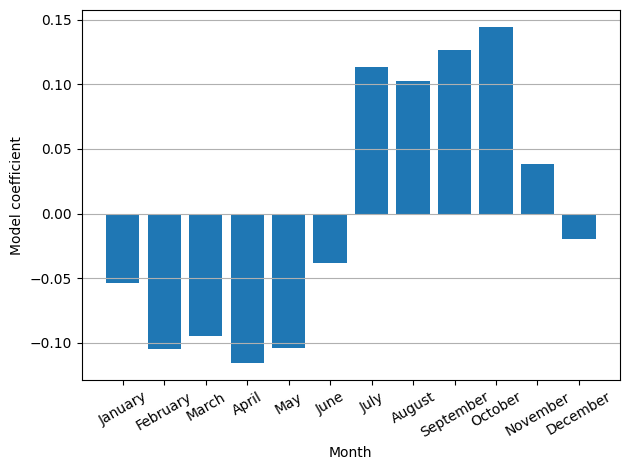

In [29]:
import matplotlib.pyplot as plt

# Corrected months list
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

# Plotting the mean of 'beta_month' across the samples
plt.bar(months, coefficients['beta_month'])

# Adding labels and title
plt.xlabel('Month')
plt.ylabel('Model coefficient')
# plt.title('Mean beta_month Coefficients by Month')

# Rotating the x-axis labels for better readability
plt.xticks(rotation=30)
plt.tight_layout()
plt.grid(axis='y')
# plt.savefig('../../docs/monthly-risk.png', bbox_inches='tight', pad_inches=0.1)
plt.show()

## Pred vs. original

In [40]:
np.log(mean_post_pred)

array([140.42129518, 109.9316173 , 109.47517224,  71.01689667,
       102.48318433, 132.56371479, 165.89774846, 448.49992789,
       687.95077339, 693.79938278, 339.51691306, 197.07909419,
       205.65241349, 136.6824661 , 155.24083002, 141.11376334,
       175.90009676, 210.84676684, 294.42756597, 394.08245817,
       449.38245442, 352.61995264, 245.53432802, 140.4628545 ,
       131.35145318, 121.86147483, 113.01724957, 147.30446974,
       130.57373007, 137.92739752, 177.93122168, 370.63354924,
                inf,          inf,          inf, 422.17623888,
       247.66772726, 247.68842395, 217.82574231, 190.20617278,
       301.93928745, 353.15404587, 555.94105104,          inf,
                inf,          inf,          inf])

In [39]:
y[X[:,3+i]==1]

Array([ 462,  460,  286,  428,  563,  713, 1992, 3075, 3102, 1500,  856,
        895,  583,  667,  603,  760,  917, 1295, 1746, 1996, 1559, 1075,
        600,  559,  516,  476,  631,  555,  587,  768, 1640, 5161, 8936,
       4079, 1874, 1085, 1085,  950,  825, 1330, 1561, 2478, 3684, 5681,
       5281, 3310, 2460], dtype=int32)

/home/beria/Documents/malaria-project/venv/lib/python3.12/site-packages/sklearn/_loss/link.py:177: RuntimeWarning: overflow encountered in exp
  return np.exp(raw_prediction, out=out)
/home/beria/Documents/malaria-project/venv/lib/python3.12/site-packages/sklearn/_loss/link.py:177: RuntimeWarning: overflow encountered in exp
  return np.exp(raw_prediction, out=out)
/home/beria/Documents/malaria-project/venv/lib/python3.12/site-packages/sklearn/_loss/link.py:177: RuntimeWarning: overflow encountered in exp
  return np.exp(raw_prediction, out=out)
/home/beria/Documents/malaria-project/venv/lib/python3.12/site-packages/sklearn/_loss/link.py:177: RuntimeWarning: overflow encountered in exp
  return np.exp(raw_prediction, out=out)
/home/beria/Documents/malaria-project/venv/lib/python3.12/site-packages/sklearn/_loss/link.py:177: RuntimeWarning: overflow encountered in exp
  return np.exp(raw_prediction, out=out)
/home/beria/Documents/malaria-project/venv/lib/python3.12/site-packages/sklearn/

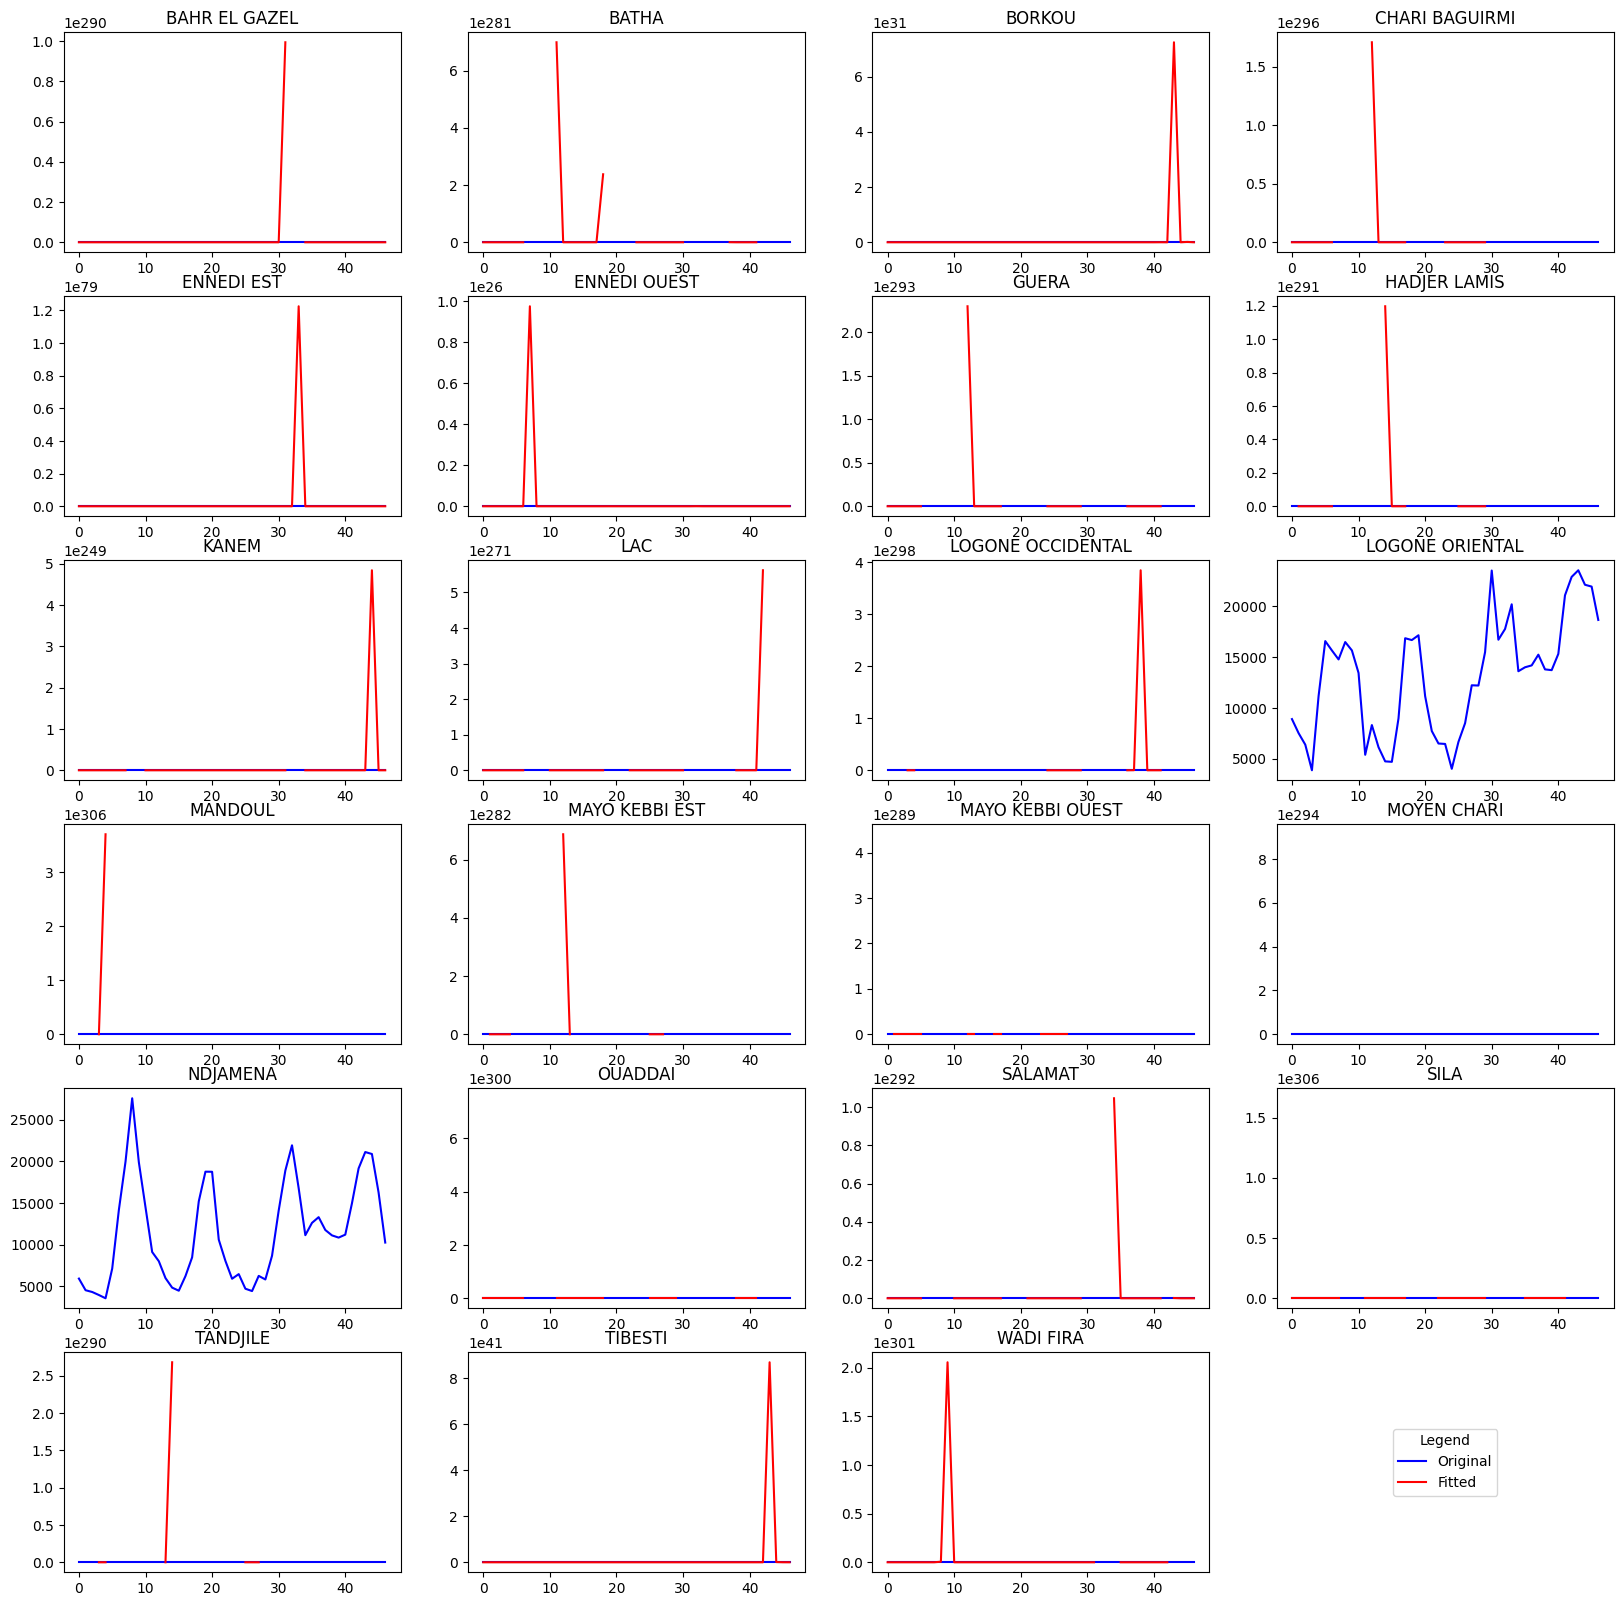

In [37]:
X = jnp.array(data[['lag_cases','t2m', 'tp'] + [col for col in data.columns if col.startswith('state_') or col.startswith('month_')]].values.tolist())
y = jnp.array(data['cases'].values.astype(int).tolist())

fig, axes = plt.subplots(6,4, figsize=(20,20))
xticks = range(47)
for i in range(23):
    idx = i // 4
    idy = i % 4
    mean_post_pred = model.predict(X[X[:,3+i]==1])
    axes[idx,idy].plot(y[X[:,3+i]==1], label='Original', color='blue')
    axes[idx,idy].plot(mean_post_pred, label='Fitted', color='red')
    # axes[idx,idy].fill_between(xticks, inf_, sup_, color='black', alpha=0.5)
    axes[idx,idy].set_title(states[i])

axes[5, 3].clear()
axes[5, 3].axis('off')
handles, labels = axes[0, 0].get_legend_handles_labels()  # Get handles and labels from the first subplot
fig.legend(handles, labels, loc='center', bbox_to_anchor=(0.5, 0.5), bbox_transform=axes[5, 3].transAxes, title='Legend')

# plt.savefig('../../docs/predictions.png', bbox_inches='tight', pad_inches=0.1)

## Residuals plot

/home/beria/Documents/malaria-project/venv/lib/python3.12/site-packages/sklearn/_loss/link.py:177: RuntimeWarning: overflow encountered in exp
  return np.exp(raw_prediction, out=out)
/home/beria/Documents/malaria-project/venv/lib/python3.12/site-packages/sklearn/_loss/link.py:177: RuntimeWarning: overflow encountered in exp
  return np.exp(raw_prediction, out=out)
/home/beria/Documents/malaria-project/venv/lib/python3.12/site-packages/sklearn/_loss/link.py:177: RuntimeWarning: overflow encountered in exp
  return np.exp(raw_prediction, out=out)
/home/beria/Documents/malaria-project/venv/lib/python3.12/site-packages/sklearn/_loss/link.py:177: RuntimeWarning: overflow encountered in exp
  return np.exp(raw_prediction, out=out)
/home/beria/Documents/malaria-project/venv/lib/python3.12/site-packages/sklearn/_loss/link.py:177: RuntimeWarning: overflow encountered in exp
  return np.exp(raw_prediction, out=out)
/home/beria/Documents/malaria-project/venv/lib/python3.12/site-packages/sklearn/

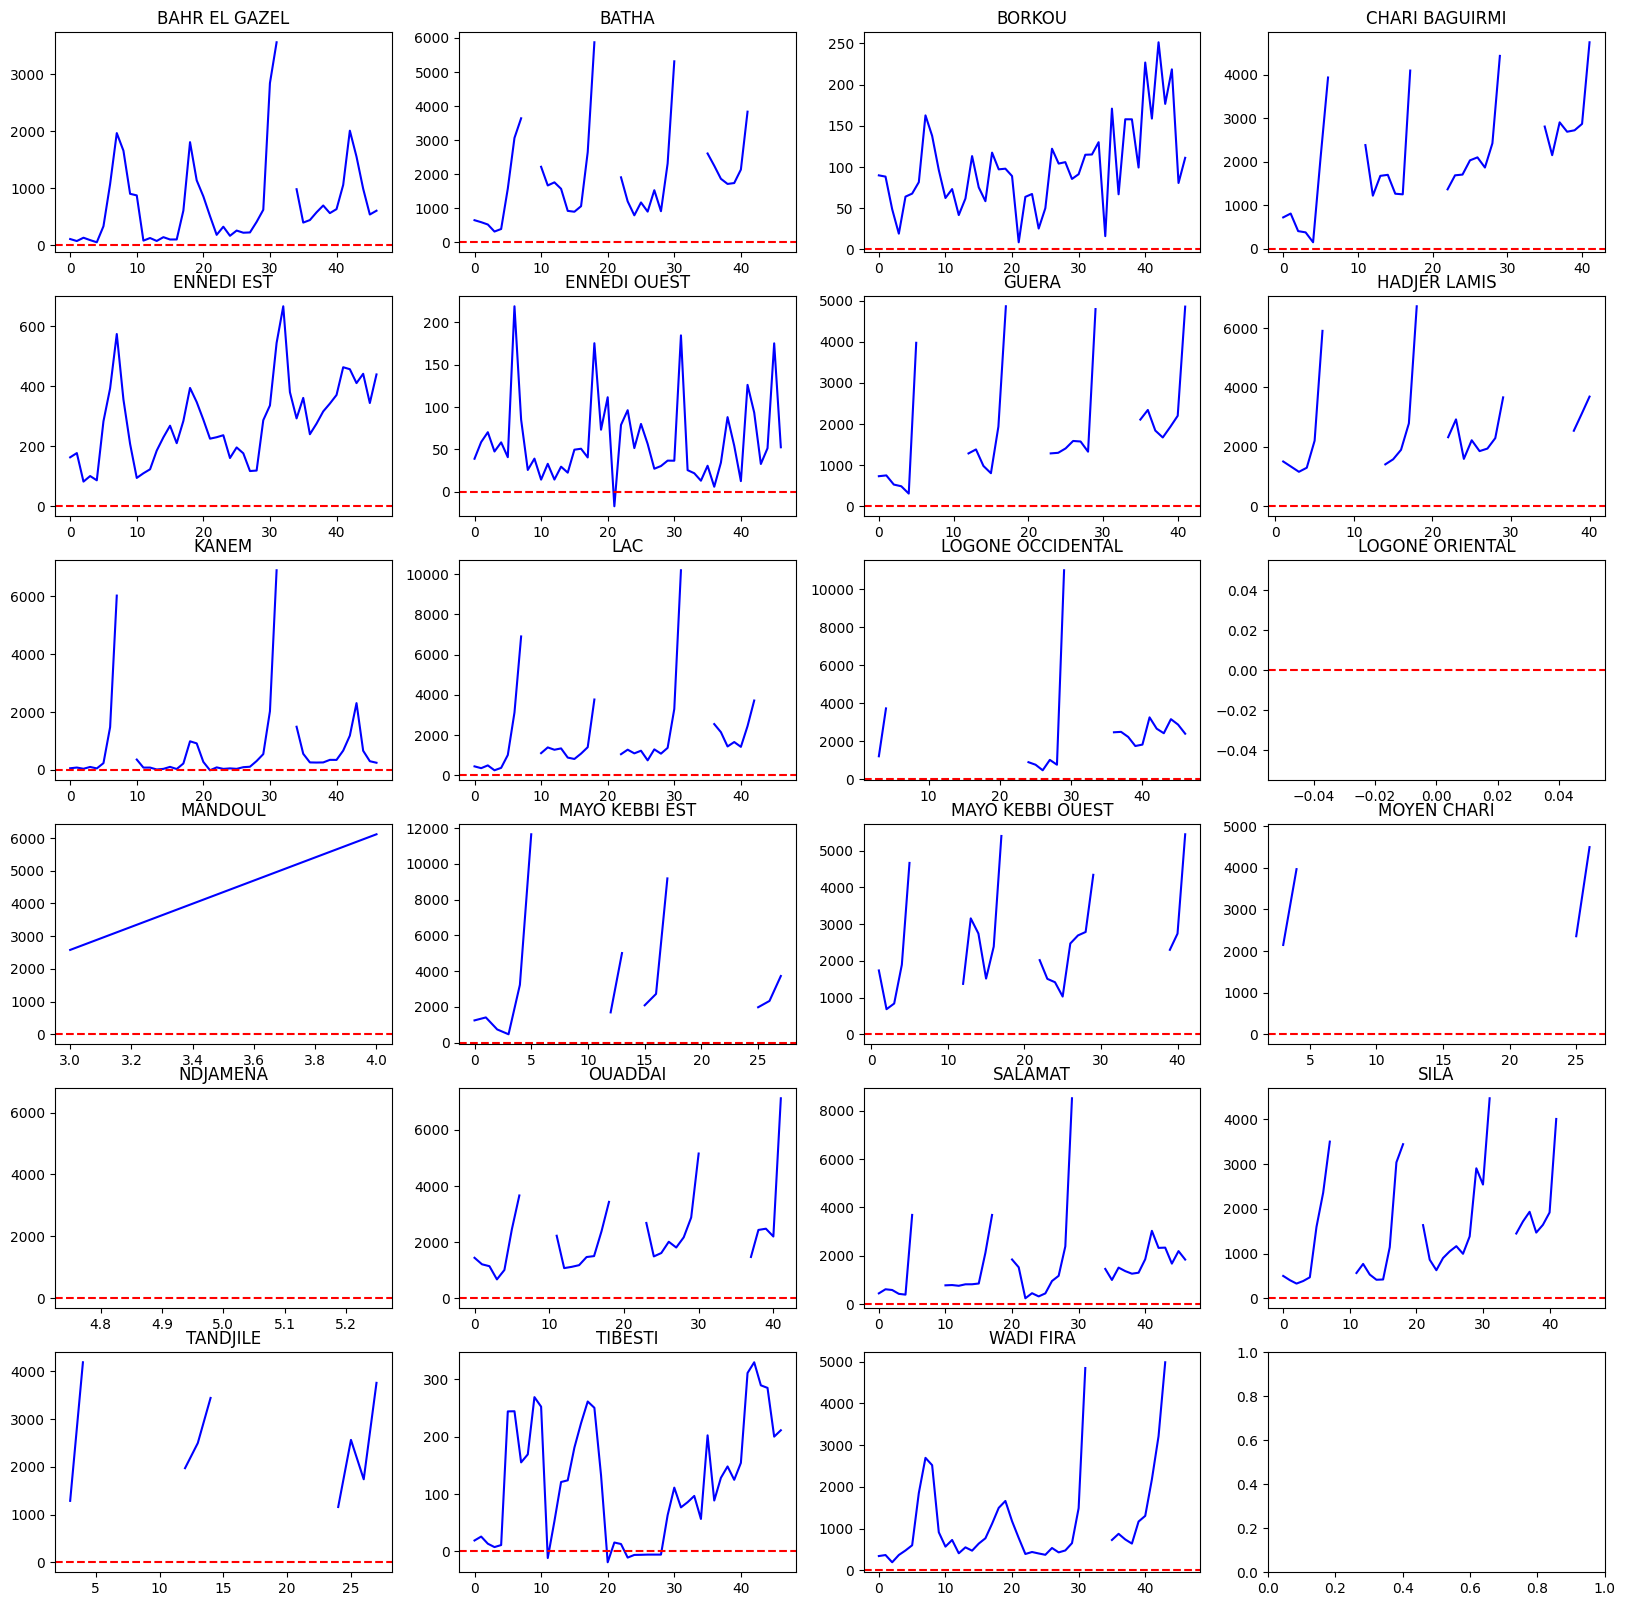

In [19]:
fig, axes = plt.subplots(6,4, figsize=(20,20))
xticks = range(47)
for i in range(23):
    idx = i // 4
    idy = i % 4
    mean_post_pred = model.predict(X[X[:,3+i]==1])
    axes[idx,idy].plot(y[X[:,3+i]==1]-mean_post_pred, label='Original', color='blue')
    axes[idx,idy].axhline(0, color='red', linestyle='--')
    axes[idx,idy].set_title(states[i])

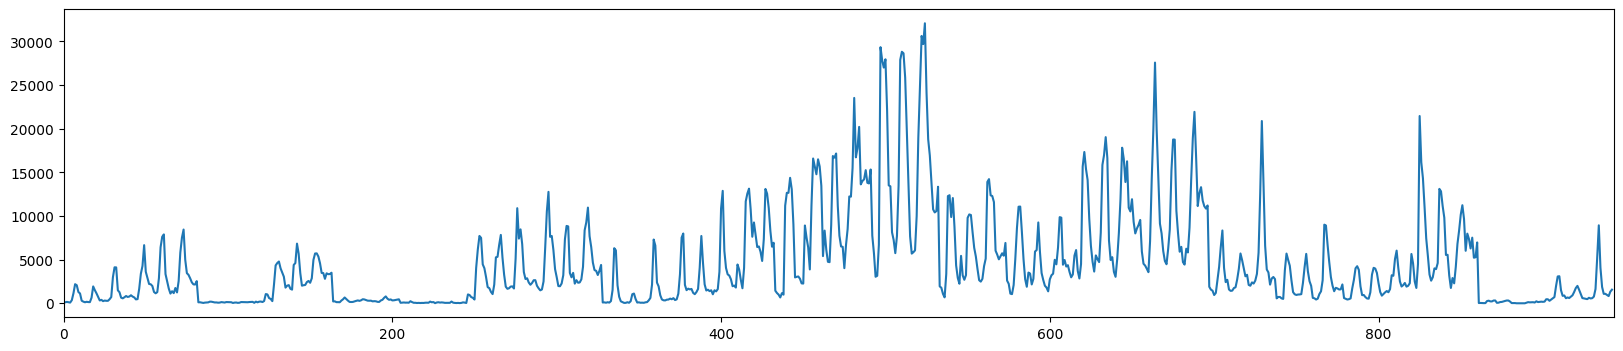

In [20]:
pred_mean = model.predict(X_train)

fig, ax = plt.subplots(1,1, figsize=(20,4))
ax.plot(y_train-pred_mean)
# plt.savefig('../../docs/residual_train.png', bbox_inches='tight', pad_inches=0.1)
plt.xlim((0,len(pred_mean)))
plt.show()

## Evaluation metrics

In [135]:
# Posterior predictive
rng_key, rng_key_ = random.split(rng_key)
samples_1 = mcmc.get_samples()
predictive = Predictive(panel_model, samples_1)
posterior_predictions = predictive(rng_key_, X=X_test)
post_obs = posterior_predictions['obs']

mean_post_pred = round(jnp.mean(post_obs, axis=0))
hpdi_post_pred = hpdi(post_obs, 0.9)

In [136]:
rmse = jnp.sqrt(((y_test - mean_post_pred)**2).mean())
mae = jnp.abs(y_test - mean_post_pred).mean()

ss_total = jnp.var(y_test)
ss_residual = jnp.mean((y_test - mean_post_pred.round()) ** 2)
r_squared = 1 - (ss_residual / ss_total)

print('RMSE:', rmse)
print('MAE:', mae)
print(f'Bayesian R-squared: {r_squared}')

RMSE: 2434.3982
MAE: 1471.7174
Bayesian R-squared: 0.8699630498886108


In [43]:
y.mean()

Array(4779.8047, dtype=float32)

In [44]:
y.var()

Array(32227782., dtype=float32)